## Begin

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


## Functions

In [ ]:
#memory optimisation
def reduce_mem_usage(df, cat_cols=[]):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype.name

        if col in cat_cols:
            df[col] = df[col].astype('category')

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [ ]:
#convert object columns to category (with see memory_usage - for control)
def convert_columns_to_catg(df, cat_cols):
    for col in cat_cols:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [ ]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=2023
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostClassifier':

            train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
            eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif algorithm.__name__ == 'LGBMClassifier':

            train_dataset = Dataset(X_train,y_train,categorical_feature=cat_features,free_raw_data=False)
            eval_dataset = Dataset(X_test,y_test,categorical_feature=cat_features,free_raw_data=False)

            model = lgb.train(params=init_params,# was 'train'
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              categorical_feature=cat_features)

        elif algorithm.__name__ == 'XGBClassifier':

            train_matrix = xgb.DMatrix(X_train,label=y_train,nthread=-1,enable_categorical=True)
            eval_matrix = xgb.DMatrix(X_test, y_test,nthread=-1,enable_categorical=True)

            model = xgb.train(params=init_params,
                              dtrain=train_matrix,
                              evals=[(train_matrix, 'dtrain'), (eval_matrix, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)
            X_test = eval_matrix


        y_pred = model.predict(X_test)
        score = roc_auc_score(y_test, y_pred)

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("\nMEAN ROC-AUC SCORE", mean_kfold_score)

    # choose best model
    best_model_index = np.argmin(score)
    best_model = models[best_model_index]

    return mean_kfold_score, best_model

In [ ]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv,
                       random_state=2023,
    ):

    estimator = algorithm(**init_params)


    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='auc',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    return model.best_params_ | init_params

In [ ]:
##function NaN values in persent%
def missing_values(df):
  missing_values = round(((df.isna().sum() / len(df)) * 100).sort_values(ascending=False), 2)
  return missing_values

In [ ]:
RANDOM_STATE = 42
results = [] # Здесь будем хранить информацию по каждой модели

## Import Libraries

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np

from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedShuffleSplit,
    StratifiedKFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
)
# from sklearn.metrics import mean_squared_error, get_scorer_names
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score

from catboost import CatBoostClassifier, Pool

import lightgbm as lgb
from lightgbm import Dataset, LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import ensemble
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Data Prepared

### train

In [ ]:
# load 'train' dataset
# %time
train = pd.read_csv('/content/drive/MyDrive/DoDo/train_target.csv')
# train = pd.read_csv('train_target.csv')
print(train.shape)
train.head(3)

(27741, 8)


,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0


#### orders

In [ ]:
# %time
orders = pd.read_csv('/content/drive/MyDrive/DoDo/orders.csv')
# orders = pd.read_csv('orders.csv')
print(orders.shape)
orders.head(3)

(611739, 18)


,OrderUUId,addressId,deliverySectorId,ClientUUId,Date,SaleDate,UnitUUId,NewClient,ClientOrderNumber,ProductUUId,CategoryId,ProductTotalPrice,MenuPrice,OrderState,OrderPaymentType,OrderTotalPrice,OrderType,apply_promo
0,020DD76CCD949AE011EDE031ED5D76FD,NaN,NaN,000D3AAC9DCABB2E11EBE0614C89D044,2023-04-21,2023-04-21T20:51:26.000Z,000D3A2480C380DA11E692CFB9F92484,0,18,000D3A240C71BE9A11E719BE2AB264A6,4,1.000,45.000,4,2,1.000,3,0
1,02164D9B0F67BC3311EE610987AF48C7,0.000,0.000,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EC9AABAD354BE051CCF1EE1F83A8D0,1,485.000,485.000,4,2,1164.000,1,0
2,02164D9B0F67BC3311EE610987AF48C7,0.000,0.000,000D3A21DA51A81411EAF10674007D74,2023-10-02,2023-10-02T21:31:32.000Z,000D3A26B5B080DF11E745FD0474B95C,0,29,11EB846583CB3BDEA80D1A7F2E184D40,1,589.000,589.000,4,2,1164.000,1,0


In [ ]:
# orders.deliverySectorId.value_counts(dropna=False)

In [ ]:
orders.addressId.fillna(0, inplace = True)
orders.deliverySectorId.fillna(0, inplace = True)

In [ ]:
orders_agg = orders.groupby("ClientUUId", as_index=False).agg(
    ClientUUId_orders_count=("ClientUUId", "count"),
    UnitUUId_count = ('UnitUUId', 'count'),
    ProductUUId_count = ('ProductUUId', "count"),
    CategoryId_count = ('CategoryId', "count"),

    addressId_mean = ("addressId", 'mean'),
    addressId_min = ("addressId", 'min'),
    addressId_max = ("addressId", 'max'),

    deliverySectorId_mean = ("addressId", 'mean'),
    deliverySectorId_min = ("addressId", 'min'),
    deliverySectorId_max = ("addressId", 'max'),

    apply_promo_sum = ('apply_promo', 'sum'),
    OrderTotalPrice_min = ('OrderTotalPrice', "min"),
    OrderTotalPrice_max = ('OrderTotalPrice', "max"),
    OrderTotalPrice_mean = ('OrderTotalPrice', "mean"),
    OrderTotalPrice_sum = ('OrderTotalPrice', "sum"),

    ProductTotalPrice_min = ('ProductTotalPrice', 'min'),
    ProductTotalPrice_max = ('ProductTotalPrice', 'max'),
    ProductTotalPrice_mean = ('ProductTotalPrice', 'mean'),
    ProductTotalPrice_sum = ('ProductTotalPrice', 'sum'),

    MenuPrice_min = ('MenuPrice', 'min'),
    MenuPrice_max = ('MenuPrice', 'max'),
    MenuPrice_mean = ('MenuPrice', 'mean'),
    MenuPrice_sum = ('MenuPrice', 'sum'),

    ClientOrderNumber_min = ('ClientOrderNumber', 'min'),
    ClientOrderNumber_max = ('ClientOrderNumber', 'max'),
    ClientOrderNumber_mean = ('ClientOrderNumber', 'mean'),
    ClientOrderNumber_sum = ('ClientOrderNumber', 'sum')# sum
)



orders_agg.head(3)

,ClientUUId,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum
0,000D3A20F23EA95811E7B7104AC23CD3,74,74,74,74,0.000,0.000,0.000,0.000,0.000,0.000,62,823.000,1565.000,1139.811,84346.000,0.000,907.500,149.743,11081.000,0.000,1210.000,201.203,14889.000,142,151,146.919,10872
1,000D3A20F23EA95811E7B88F5E50100B,52,52,52,52,0.000,0.000,0.000,0.000,0.000,0.000,6,524.000,1708.000,1150.288,59815.000,0.000,479.000,173.558,9025.000,0.000,479.000,193.077,10040.000,58,66,62.096,3229
2,000D3A20F23EA95811E7B8BD71C73877,35,35,35,35,0.000,0.000,0.000,0.000,0.000,0.000,5,130.000,1523.000,945.600,33096.000,0.000,570.000,245.000,8575.000,0.000,719.000,302.400,10584.000,112,121,116.943,4093


In [ ]:
orders.SaleDate = pd.to_datetime(orders.SaleDate, utc=True)

# orders['orders_saledate_year'] = orders.SaleDate.dt.year.astype('int32')
orders['orders_saledate_month'] = orders.SaleDate.dt.month.astype('int32')
orders['orders_saledate_day'] = orders.SaleDate.dt.day.astype('int32')
orders['orders_saledate_dayofweek'] = orders.SaleDate.dt.dayofweek.astype('int32')
orders['orders_saledate_hour'] = orders.SaleDate.dt.hour.astype('int32')


orders_saledate_month = orders.groupby(['ClientUUId'])['orders_saledate_month'].agg(lambda x: x.value_counts().index[0])
orders_saledate_day = orders.groupby(['ClientUUId'])['orders_saledate_day'].agg(lambda x: x.value_counts().index[0])
orders_saledate_dayofweek = orders.groupby(['ClientUUId'])['orders_saledate_dayofweek'].agg(lambda x: x.value_counts().index[0])
orders_saledate_hour = orders.groupby(['ClientUUId'])['orders_saledate_hour'].agg(lambda x: x.value_counts().index[0])

orders_agg = orders_agg.merge(orders_saledate_month, on="ClientUUId", how="left")
orders_agg = orders_agg.merge(orders_saledate_day, on="ClientUUId", how="left")
orders_agg = orders_agg.merge(orders_saledate_dayofweek, on="ClientUUId", how="left")
orders_agg = orders_agg.merge(orders_saledate_hour, on="ClientUUId", how="left")

# orders_agg.head(5)

In [ ]:
ProductUUId = orders.groupby(['ClientUUId'])['ProductUUId'].agg(lambda x: x.value_counts().index[0])
orders_agg = orders_agg.merge(ProductUUId, on="ClientUUId", how="left")

OrderState = orders.groupby(['ClientUUId'])['OrderState'].agg(lambda x: x.value_counts().index[0])
orders_agg = orders_agg.merge(OrderState, on="ClientUUId", how="left")

OrderPaymentType = orders.groupby(['ClientUUId'])['OrderPaymentType'].agg(lambda x: x.value_counts().index[0])
orders_agg = orders_agg.merge(OrderPaymentType, on="ClientUUId", how="left")

CategoryId = orders.groupby(['ClientUUId'])['CategoryId'].agg(lambda x: x.value_counts().index[0])
orders_agg = orders_agg.merge(CategoryId, on="ClientUUId", how="left")

orders_agg.head(5)

,ClientUUId,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId
0,000D3A20F23EA95811E7B7104AC23CD3,74,74,74,74,0.000,0.000,0.000,0.000,0.000,0.000,62,823.000,1565.000,1139.811,84346.000,0.000,907.500,149.743,11081.000,0.000,1210.000,201.203,14889.000,142,151,146.919,10872,10,8,3,21,000D3A240C71BE9A11E719BE2AB2D427,4,0,6
1,000D3A20F23EA95811E7B88F5E50100B,52,52,52,52,0.000,0.000,0.000,0.000,0.000,0.000,6,524.000,1708.000,1150.288,59815.000,0.000,479.000,173.558,9025.000,0.000,479.000,193.077,10040.000,58,66,62.096,3229,10,31,1,20,000D3A39D824A82E11E9A18231161F85,4,2,1
2,000D3A20F23EA95811E7B8BD71C73877,35,35,35,35,0.000,0.000,0.000,0.000,0.000,0.000,5,130.000,1523.000,945.600,33096.000,0.000,570.000,245.000,8575.000,0.000,719.000,302.400,10584.000,112,121,116.943,4093,10,21,5,13,000D3A240C71BE9A11E719BE2AB264A6,4,2,1
3,000D3A20F23EA95811E7B95FE7E6321C,48,48,48,48,0.000,0.000,0.000,0.000,0.000,0.000,5,0.000,1378.000,904.229,43403.000,0.000,873.260,174.021,8353.000,0.000,1000.000,217.917,10460.000,86,96,90.021,4321,7,4,0,22,11EBADD5B90B8B4F0F2EF40F4E6B5B70,4,2,3
4,000D3A20F23EA95811E7B969B5BD2C3F,34,34,34,34,0.000,0.000,0.000,0.000,0.000,0.000,0,231.000,1645.000,1170.529,39798.000,0.000,987.000,330.176,11226.000,0.000,987.000,395.559,13449.000,107,116,111.206,3781,8,2,5,19,11EBB830B8BEDFC180C29D4BD3477A30,4,2,1


In [ ]:
train = train.merge(orders_agg, on="ClientUUId", how="left")
train.head(3)

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,699,200,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,1249,25,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",2023-11-02T00:00:00.000Z,2023-11-05T23:59:00.000Z,799,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.LocalBeginDate = pd.to_datetime(train.LocalBeginDate, utc=True)
train.LocalEndDate = pd.to_datetime(train.LocalEndDate, utc=True)

# train['LocalBeginDate_year'] = train.LocalBeginDate.dt.year.astype('int32')
train['LocalBeginDate_month'] = train.LocalBeginDate.dt.month.astype('int32')
train['LocalBeginDate_day'] = train.LocalBeginDate.dt.day.astype('int32')

# train['LocalEndDate_year'] = train.LocalEndDate.dt.year.astype('int32')
train['LocalEndDate_month'] = train.LocalEndDate.dt.month.astype('int32')
train['LocalEndDate_day'] = train.LocalEndDate.dt.day.astype('int32')

train.drop(columns=['LocalBeginDate', 'LocalEndDate'], inplace = True)
train.head(3)

,ClientUUId,Id,OrderType,OrderPrice,Discount,apply_promo,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,LocalBeginDate_month,LocalBeginDate_day,LocalEndDate_month,LocalEndDate_day
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",699,200,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",1249,25,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",799,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2,11,5


### mobile_events

In [ ]:
# %time
mobile_events = pd.read_csv('/content/drive/MyDrive/DoDo/mobile_events.csv')
# mobile_events = pd.read_csv('mobile_events.csv')
print(mobile_events.shape)
mobile_events.head(3)

(3916654, 5)


,ClientUUId,VisitToken,EventName,Platform,Timestamp
0,000D3A22FA54A81611EB315CF5443815,976627AD-76DC-41D9-981E-F2A6CA14B3A9,screen_menu,ios,2023-10-29T16:14:21.343Z
1,2A4A64AF719E994511EE3F2D8B31E188,5b22e610-c71e-4b6a-a842-71e8575ece87,screen_menu,android,2023-10-29T11:04:36.4840000Z
2,000D3AAC977BBB2F11ECDD081F5481AE,BDCEB72F-2B6A-4565-801A-6CB729279C6F,open_app,ios,2023-10-29T11:14:34.723Z


In [ ]:
mobile_events.Timestamp = pd.to_datetime(mobile_events.Timestamp, utc=True)

# mobile_events['Timestamp_year'] = mobile_events.Timestamp.dt.year.astype('int32')
mobile_events['Timestamp_month'] = mobile_events.Timestamp.dt.month.astype('int32')
mobile_events['Timestamp_day'] = mobile_events.Timestamp.dt.day.astype('int32')
mobile_events['Timestamp_dayofweek'] = mobile_events.Timestamp.dt.dayofweek.astype('int32')
mobile_events['Timestamp_hour'] = mobile_events.Timestamp.dt.hour.astype('int32')


mobile_events.drop(columns=['Timestamp'], inplace = True)
# mobile_events

In [ ]:
mobile_events_agg = mobile_events.groupby("ClientUUId", as_index=False).agg(
    ClientUUId_event_count=("ClientUUId", "count"),
    VisitToken_event_count =("VisitToken", 'count')
)

# mobile_events_agg.head(3)

In [ ]:
Platform = mobile_events.groupby(['ClientUUId'])['Platform'].agg(lambda x: x.value_counts().index[0])
EventName = mobile_events.groupby(['ClientUUId'])['EventName'].agg(lambda x: x.value_counts().index[0])

mobile_events_agg = mobile_events_agg.merge(Platform, on="ClientUUId", how="left")
mobile_events_agg = mobile_events_agg.merge(EventName, on="ClientUUId", how="left")

In [ ]:
# Timestamp_year = mobile_events.groupby(['ClientUUId'])['Timestamp_year'].agg(lambda x: x.value_counts().index[0])
# mobile_events_agg = mobile_events_agg.merge(Timestamp_year, on="ClientUUId", how="left")
Timestamp_month = mobile_events.groupby(['ClientUUId'])['Timestamp_month'].agg(lambda x: x.value_counts().index[0])
Timestamp_day = mobile_events.groupby(['ClientUUId'])['Timestamp_day'].agg(lambda x: x.value_counts().index[0])
mobile_events_agg = mobile_events_agg.merge(Timestamp_month, on="ClientUUId", how="left")
mobile_events_agg = mobile_events_agg.merge(Timestamp_day, on="ClientUUId", how="left")


Timestamp_dayofweek = mobile_events.groupby(['ClientUUId'])['Timestamp_dayofweek'].agg(lambda x: x.value_counts().index[0])
Timestamp_hour = mobile_events.groupby(['ClientUUId'])['Timestamp_hour'].agg(lambda x: x.value_counts().index[0])
mobile_events_agg = mobile_events_agg.merge(Timestamp_dayofweek, on="ClientUUId", how="left")
mobile_events_agg = mobile_events_agg.merge(Timestamp_hour, on="ClientUUId", how="left")

In [ ]:
train = train.merge(mobile_events_agg, on="ClientUUId", how="left")
train.head(3)

,ClientUUId,Id,OrderType,OrderPrice,Discount,apply_promo,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,LocalBeginDate_month,LocalBeginDate_day,LocalEndDate_month,LocalEndDate_day,ClientUUId_event_count,VisitToken_event_count,Platform,EventName,Timestamp_month,Timestamp_day,Timestamp_dayofweek,Timestamp_hour
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",699,200,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",1249,25,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",799,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2,11,5,97.000,97.000,android,screen_profile,10.000,8.000,6.000,13.000


### Clients_promo_october

In [ ]:
# %time
clients_promo_october = pd.read_csv('/content/drive/MyDrive/DoDo/clients_promo_october.csv')
# clients_promo_october = pd.read_csv('clients_promo_october.csv')
print(clients_promo_october.shape)
clients_promo_october.head(3)

(477275, 7)


,ClientUUId,Id,LocalBeginDate,LocalEndDate,OrderType,OrderPrice,Discount
0,000D3A20F23EA95811E7B7104AC23CD3,6,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,25
1,000D3A20F23EA95811E7B7D79FAABAA1,5,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1299,300
2,000D3A20F23EA95811E7B8BD71C73877,7,2023-10-12T00:00:00.000Z,2023-10-15T23:59:00.000Z,"1,2,3",1249,200


In [ ]:
clients_promo_october.LocalBeginDate = pd.to_datetime(clients_promo_october.LocalBeginDate, utc=True)
clients_promo_october.LocalEndDate = pd.to_datetime(clients_promo_october.LocalEndDate, utc=True)

# clients_promo_october['LocalBeginDate_promo_year'] = clients_promo_october.LocalBeginDate.dt.year.astype('int32')
clients_promo_october['LocalBeginDate_promo_month'] = clients_promo_october.LocalBeginDate.dt.month.astype('int32')
clients_promo_october['LocalBeginDate_promo_day'] = clients_promo_october.LocalBeginDate.dt.day.astype('int32')

# clients_promo_october['LocalEndDate_promo_year'] = clients_promo_october.LocalEndDate.dt.year.astype('int32')
clients_promo_october['LocalEndDate_promo_month'] = clients_promo_october.LocalEndDate.dt.month.astype('int32')
clients_promo_october['LocalEndDate_promo_day'] = clients_promo_october.LocalEndDate.dt.day.astype('int32')

clients_promo_october.drop(columns=['LocalBeginDate', 'LocalEndDate'], inplace = True)
clients_promo_october.head(5)

,ClientUUId,Id,OrderType,OrderPrice,Discount,LocalBeginDate_promo_month,LocalBeginDate_promo_day,LocalEndDate_promo_month,LocalEndDate_promo_day
0,000D3A20F23EA95811E7B7104AC23CD3,6,"1,2,3",1299,25,10,12,10,15
1,000D3A20F23EA95811E7B7D79FAABAA1,5,"1,2,3",1299,300,10,12,10,15
2,000D3A20F23EA95811E7B8BD71C73877,7,"1,2,3",1249,200,10,12,10,15
3,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",1249,30,10,12,10,15
4,000D3A20F23EA95811E7BD373E79565E,6,"1,2,3",1299,20,10,12,10,15


In [ ]:
clients_promo_october_agg = clients_promo_october.groupby("ClientUUId", as_index=False).agg(
    ClientUUId_event_count=("ClientUUId", "count"),
    OrderPrice_promo_min = ('OrderPrice', "min"),
    OrderPrice_promo_max = ('OrderPrice', "max"),
    OrderPrice_promo_mean = ('OrderPrice', "mean"),
    OrderPrice_promo_sum = ('OrderPrice', "sum"),

    Discount_promo_min = ('Discount', "min"),
    Discount_promo_max = ('Discount', "max"),
    Discount_promo_mean = ('Discount', "mean"),
    Discount_promo_sum = ('Discount', "sum"),
)

# clients_promo_october_agg.head(3)

In [ ]:
LocalBeginDate_promo_month = clients_promo_october.groupby(['ClientUUId'])['LocalBeginDate_promo_month'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(LocalBeginDate_promo_month, on="ClientUUId", how="left")
LocalBeginDate_promo_day = clients_promo_october.groupby(['ClientUUId'])['LocalBeginDate_promo_day'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(LocalBeginDate_promo_day, on="ClientUUId", how="left")


LocalEndDate_promo_month = clients_promo_october.groupby(['ClientUUId'])['LocalEndDate_promo_month'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(LocalEndDate_promo_month, on="ClientUUId", how="left")
LocalEndDate_promo_day = clients_promo_october.groupby(['ClientUUId'])['LocalEndDate_promo_day'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(LocalEndDate_promo_day, on="ClientUUId", how="left")

# clients_promo_october_agg

In [ ]:
id_promo_mode = clients_promo_october.groupby(['ClientUUId'])['Id'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(id_promo_mode, on="ClientUUId", how="left")

OrderType_promo = clients_promo_october.groupby(['ClientUUId'])['OrderType'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(OrderType_promo, on="ClientUUId", how="left")

OrderPrice_promo_mode = clients_promo_october.groupby(['ClientUUId'])['OrderPrice'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(OrderPrice_promo_mode, on="ClientUUId", how="left")

Discount_promo_mode = clients_promo_october.groupby(['ClientUUId'])['Discount'].agg(lambda x: x.value_counts().index[0])
clients_promo_october_agg = clients_promo_october_agg.merge(Discount_promo_mode, on="ClientUUId", how="left")
# clients_promo_october_agg.head(5)

In [ ]:
train = train.merge(clients_promo_october_agg, on="ClientUUId", how="left")
train.head(3)

,ClientUUId,Id_x,OrderType_x,OrderPrice_x,Discount_x,apply_promo,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,LocalBeginDate_month,LocalBeginDate_day,LocalEndDate_month,LocalEndDate_day,ClientUUId_event_count_x,VisitToken_event_count,Platform,EventName,Timestamp_month,Timestamp_day,Timestamp_dayofweek,Timestamp_hour,ClientUUId_event_count_y,OrderPrice_promo_min,OrderPrice_promo_max,OrderPrice_promo_mean,OrderPrice_promo_sum,Discount_promo_min,Discount_promo_max,Discount_promo_mean,Discount_promo_sum,LocalBeginDate_promo_month,LocalBeginDate_promo_day,LocalEndDate_promo_month,LocalEndDate_promo_day,Id_y,OrderType_y,OrderPrice_y,Discount_y
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",699,200,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000,14,699,1299,1002.571,14036,20,250,80.357,1125,10,12,10,15,6,"1,2,3",1249,30
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",1249,25,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.152,9179.000,40.000,649.000,369.697,12200.000,97.000,118.000,105.485,3481.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000,14,699,1299,1002.571,14036,20,250,80.357,1125,10,12,10,15,6,"1,2,3",1249,30
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",799,200,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,2,11,5,97.000,97.000,android,screen_profile,10.000,8.000,6.000,13.000,12,699,1299,982.333,11788,20,300,94.583,1135,10,12,10,15,6,"1,2,3",1299,25


# Fill NA

In [ ]:
# missing_values(train)

In [ ]:
train['OrderTotalPrice_min'].fillna(train['OrderTotalPrice_min'].mean().round(), inplace = True)
train['OrderTotalPrice_max'].fillna(train['OrderTotalPrice_max'].mean().round(), inplace = True)

train['OrderTotalPrice_mean'].fillna(train['OrderTotalPrice_mean'].mean().round(), inplace = True)
train['OrderTotalPrice_min'].fillna(train['OrderTotalPrice_min'].mean().round(), inplace = True)
train['OrderTotalPrice_max'].fillna(train['OrderTotalPrice_max'].mean().round(), inplace = True)

train['ClientOrderNumber_max'].fillna(train['ClientOrderNumber_max'].mean().round(), inplace = True)
train['ClientOrderNumber_min'].fillna(train['ClientOrderNumber_min'].mean().round(), inplace = True)
train['ClientOrderNumber_mean'].fillna(train['ClientOrderNumber_mean'].mean().round(), inplace = True)
train['ClientOrderNumber_sum'].fillna(train['ClientOrderNumber_sum'].mean().round(), inplace = True)

train['ProductTotalPrice_mean'].fillna(train['ProductTotalPrice_mean'].mean().round(), inplace = True)
train['ProductTotalPrice_max'].fillna(train['ProductTotalPrice_max'].mean().round(), inplace = True)
train['ProductTotalPrice_min'].fillna(train['ProductTotalPrice_min'].mean().round(), inplace = True)

train['MenuPrice_max'].fillna(train['MenuPrice_max'].mean().round(), inplace = True)
train['MenuPrice_min'].fillna(train['MenuPrice_min'].mean().round(), inplace = True)
train['MenuPrice_mean'].fillna(train['MenuPrice_mean'].mean().round(), inplace = True)

train['apply_promo_sum'].fillna(0, inplace = True)
train['ClientUUId_event_count_x'].fillna(0, inplace = True)
train['ClientUUId_orders_count'].fillna(0, inplace = True)
train['OrderState'].fillna(4, inplace = True)
train['UnitUUId_count'].fillna(0, inplace = True)
train['OrderPaymentType'].fillna(3, inplace = True)
train['ProductUUId'].fillna('other', inplace = True)
train['CategoryId'].fillna(0, inplace = True)

train['EventName'].fillna('screen_menu', inplace = True)
train['Platform'].fillna('ios', inplace = True)


train['ProductUUId_count'].fillna(0, inplace = True)
train['ProductTotalPrice_sum'].fillna(0, inplace = True)
train['CategoryId_count'].fillna(0, inplace = True)
train['MenuPrice_sum'].fillna(0, inplace = True)
train['OrderTotalPrice_sum'].fillna(0, inplace = True)

train['Timestamp_month'].fillna(100, inplace = True)
train['Timestamp_day'].fillna(100, inplace = True)
train['Timestamp_dayofweek'].fillna(100, inplace = True)
train['Timestamp_hour'].fillna(100, inplace = True)

train['orders_saledate_hour'].fillna(100, inplace = True)
train['orders_saledate_dayofweek'].fillna(100, inplace = True)
train['orders_saledate_day'].fillna(100, inplace = True)
train['orders_saledate_month'].fillna(100, inplace = True)

train['VisitToken_event_count'].fillna(1000, inplace = True)

train['addressId_min'].fillna(0, inplace = True)
train['addressId_max'].fillna(0, inplace = True)
train['addressId_mean'].fillna(0, inplace = True)
train['deliverySectorId_min'].fillna(0, inplace = True)
train['deliverySectorId_mean'].fillna(0, inplace = True)
train['deliverySectorId_max'].fillna(0, inplace = True)


# Modeling

In [ ]:
reduce_mem_usage(train)

,ClientUUId,Id_x,OrderType_x,OrderPrice_x,Discount_x,apply_promo,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,LocalBeginDate_month,LocalBeginDate_day,LocalEndDate_month,LocalEndDate_day,ClientUUId_event_count_x,VisitToken_event_count,Platform,EventName,Timestamp_month,Timestamp_day,Timestamp_dayofweek,Timestamp_hour,ClientUUId_event_count_y,OrderPrice_promo_min,OrderPrice_promo_max,OrderPrice_promo_mean,OrderPrice_promo_sum,Discount_promo_min,Discount_promo_max,Discount_promo_mean,Discount_promo_sum,LocalBeginDate_promo_month,LocalBeginDate_promo_day,LocalEndDate_promo_month,LocalEndDate_promo_day,Id_y,OrderType_y,OrderPrice_y,Discount_y
0,000D3A20F23EA95811E7B99F3ED09FC8,7,"2,3",699,200,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.250,9179.000,40.000,649.000,369.750,12200.000,97.000,118.000,105.500,3480.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000,14,699,1299,1002.500,14036,20,250,80.375,1125,10,12,10,15,6,"1,2,3",1249,30
1,000D3A20F23EA95811E7B99F3ED09FC8,6,"1,2,3",1249,25,0,33.000,33.000,33.000,33.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,70.000,5039.000,1853.727,61173.000,0.000,513.000,278.250,9179.000,40.000,649.000,369.750,12200.000,97.000,118.000,105.500,3480.000,9.000,5.000,1.000,11.000,000D3A24D2B7A94311E857AF49FDC657,4.000,2.000,1.000,11,2,11,5,187.000,187.000,ios,screen_menu,10.000,16.000,0.000,17.000,14,699,1299,1002.500,14036,20,250,80.375,1125,10,12,10,15,6,"1,2,3",1249,30
2,000D3A20F23EA95811E7BD373E79565E,5,"2,3",799,200,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,410.000,1648.000,1036.000,0.000,4.000,735.000,258.000,0.000,28.000,819.000,314.000,0.000,45.000,55.000,50.000,1930.000,100.000,100.000,100.000,100.000,other,4.000,3.000,0.000,11,2,11,5,97.000,97.000,android,screen_profile,10.000,8.000,6.000,13.000,12,699,1299,982.500,11788,20,300,94.562,1135,10,12,10,15,6,"1,2,3",1299,25
3,000D3A20F23EA95811E7BD373E79565E,5,"1,2,3",1249,250,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,410.000,1648.000,1036.000,0.000,4.000,735.000,258.000,0.000,28.000,819.000,314.000,0.000,45.000,55.000,50.000,1930.000,100.000,100.000,100.000,100.000,other,4.000,3.000,0.000,11,2,11,5,97.000,97.000,android,screen_profile,10.000,8.000,6.000,13.000,12,699,1299,982.500,11788,20,300,94.562,1135,10,12,10,15,6,"1,2,3",1299,25
4,000D3A20F23EA95811E7BDAE71CD3F33,6,"2,3",699,30,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,410.000,1648.000,1036.000,0.000,4.000,735.000,258.000,0.000,28.000,819.000,314.000,0.000,45.000,55.000,50.000,1930.000,100.000,100.000,100.000,100.000,other,4.000,3.000,0.000,11,2,11,5,103.000,103.000,android,open_app,10.000,2.000,0.000,16.000,18,699,1299,985.000,17732,25,300,133.875,2410,10,12,10,15,6,"1,2,3",699,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27736,82EDBCD6CE60978F11EDC591DCA75401,5,"2,3",799,200,0,42.000,42.000,42.000,42.000,1717823.250,0.000,18037144.000,1717823.250,0.000,18037144.000,10.000,210.000,2053.000,1443.595,60631.

In [ ]:
# train.info()

In [ ]:
cat_features = [ 'ClientUUId',
                 'OrderType_x',
                 'ProductUUId',
                 'Platform',
                 'EventName',
                 'OrderType_y',
               ]
targets = ["apply_promo"]
features2drop = ["apply_promo"]

convert_columns_to_catg(train, cat_features)

print('\n')

# Отбираем итоговый набор признаков для использования моделью
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features", cat_features)
print("num_features", num_features)
print("targets", targets)

converting ClientUUId                     size:  2.47	->	 2.24
converting OrderType_x                    size:  1.69	->	 0.03
converting ProductUUId                    size:  2.13	->	 0.09
converting Platform                       size:  1.72	->	 0.03
converting EventName                      size:  1.87	->	 0.03
converting OrderType_y                    size:  1.72	->	 0.03


cat_features ['ClientUUId', 'OrderType_x', 'ProductUUId', 'Platform', 'EventName', 'OrderType_y']
num_features ['Id_x', 'OrderPrice_x', 'Discount_x', 'ClientUUId_orders_count', 'UnitUUId_count', 'ProductUUId_count', 'CategoryId_count', 'addressId_mean', 'addressId_min', 'addressId_max', 'deliverySectorId_mean', 'deliverySectorId_min', 'deliverySectorId_max', 'apply_promo_sum', 'OrderTotalPrice_min', 'OrderTotalPrice_max', 'OrderTotalPrice_mean', 'OrderTotalPrice_sum', 'ProductTotalPrice_min', 'ProductTotalPrice_max', 'ProductTotalPrice_mean', 'ProductTotalPrice_sum', 'MenuPrice_min', 'MenuPrice_max', 'MenuPrice_m

In [ ]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["apply_promo"]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
# случ удаление данных
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(X, y)

## Catboost

In [ ]:
cb_init_params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'random_seed': RANDOM_STATE,
    'thread_count': -1,
    'learning_rate': 0.15,
#     'task_type': 'GPU',
#     'border_count': 254,
}

cb_score, cb_model = train_model(
    algorithm=CatBoostClassifier,
    X=X_train, y=y_train,
    init_params=cb_init_params,
    early_stopping_rounds=100,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)


#077

========= TRAINING CatBoostClassifier =========
FOLD 0: SCORE 0.7645784081954294
FOLD 1: SCORE 0.754931174516112
FOLD 2: SCORE 0.7361525661005309

MEAN ROC-AUC SCORE 0.74


In [ ]:
# посмотрим на важность признаков катбуста
fi = cb_model.get_feature_importance(prettified=True)
# fi['Feature Id'].to_list()
# list(fi[fi.Importances <= 0]['Feature Id'])
fi

,Feature Id,Importances
0,ClientUUId,25.947
1,apply_promo_sum,8.665
2,Timestamp_hour,3.442
3,ClientUUId_event_count_x,3.274
4,VisitToken_event_count,3.241
...,...,...
64,LocalEndDate_month,0.000
65,LocalEndDate_day,0.000
66,Timestamp_month,0.000
67,LocalBeginDate_promo_month,0.000


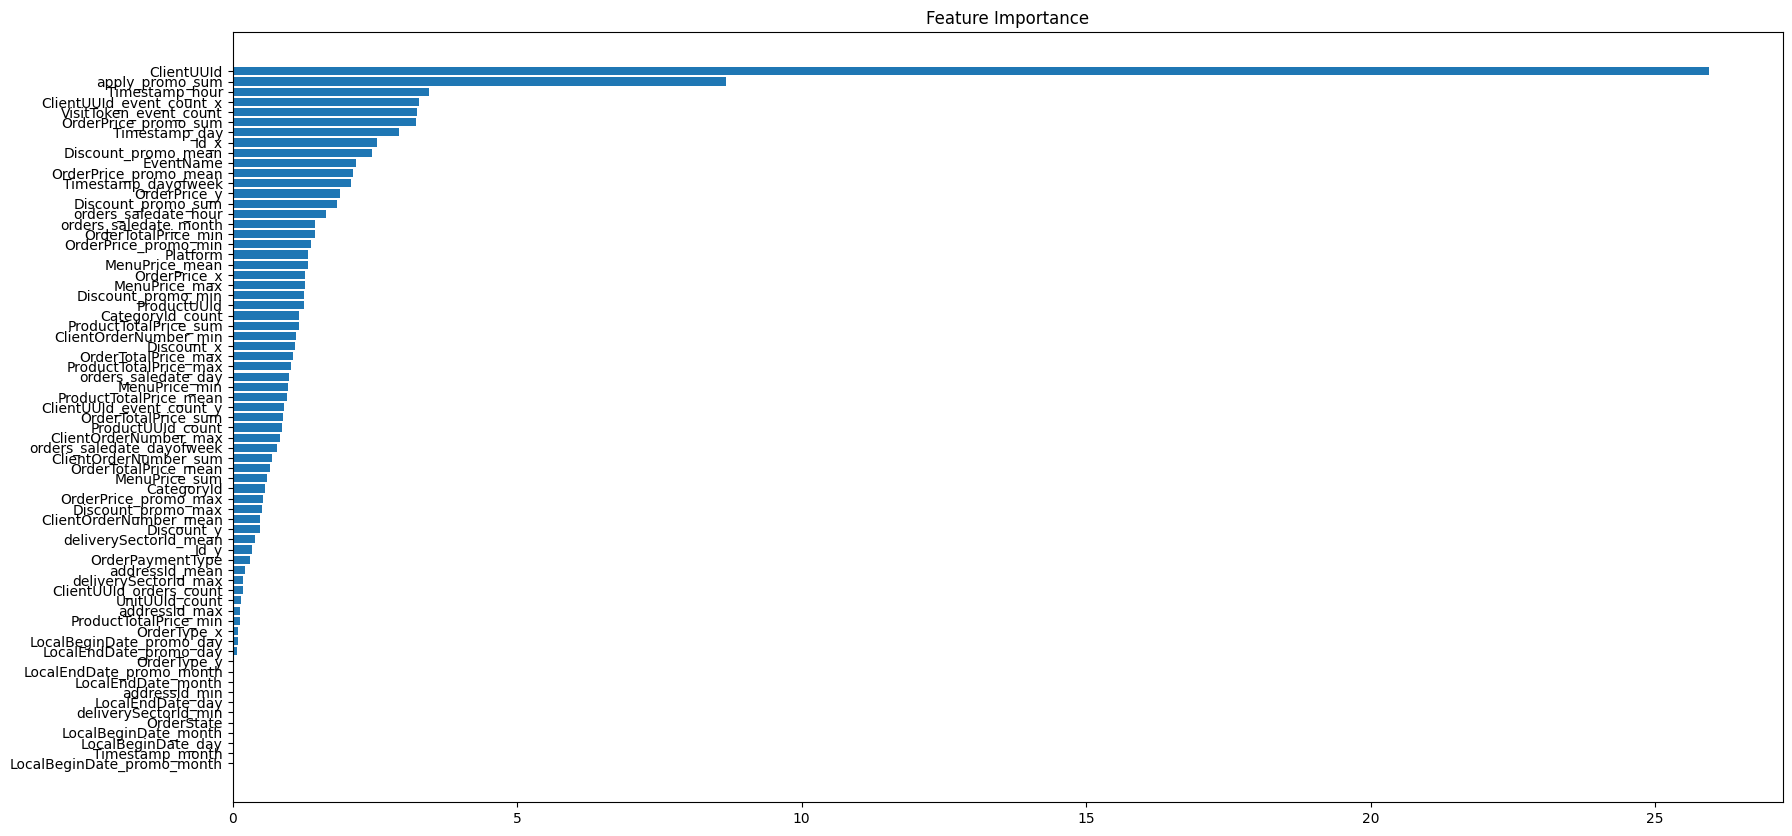

In [ ]:
feature_importance = cb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

## LightGBM


In [ ]:
X_lgb = X_train.copy()
le = LabelEncoder()
for col in cat_features:
    X_lgb[col] = le.fit_transform(X_lgb[col])

In [ ]:
lgb_init_params = {
    'n_jobs': -1,
    'random_state': RANDOM_STATE,
    'verbosity' : -1,
    'device': 'cpu',
    'learning_rate': 0.20,
#     'reg_alpha': 0.15,
    "objective": "binary"
    }


lgb_score, lgb_model = train_model(
    algorithm=LGBMClassifier,
    X=X_lgb, y=y_train,
    init_params=lgb_init_params,
    early_stopping_rounds=100,
    cat_features=cat_features,
    random_seed=RANDOM_STATE,

)

#0.743
#0.782
#0.7954
#0.829

========= TRAINING LGBMClassifier =========
FOLD 0: SCORE 0.8132781717888101
FOLD 1: SCORE 0.8226623068403566
FOLD 2: SCORE 0.8056472701339181

MEAN ROC-AUC SCORE 0.807


## XGBoost

In [ ]:
X_xgb = X_train.copy()
for col in cat_features:
    X_xgb[col] = X_xgb[col].astype('category')

In [ ]:
xgb_init_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.28,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'reg_alpha' : 0.2,
    'verbosity': 0,
#     'enable_categorical' : True
   }


xgb_score, xgb_model = train_model(
    algorithm=XGBClassifier,
    X=X_xgb, y=y_train,
    init_params=xgb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)
# MEAN ROC-AUC SCORE 0.7383
#0.753

========= TRAINING XGBClassifier =========
FOLD 0: SCORE 0.7840162857893355
FOLD 1: SCORE 0.7724539844944887
FOLD 2: SCORE 0.7612324678412002

MEAN ROC-AUC SCORE 0.7637


## Another models

In [ ]:
classifiers = {
    "lr": LogisticRegression(),
    "svc": SVC(),
    "knn": KNeighborsClassifier(),
    "dtree": DecisionTreeClassifier(),
    "bagging": ensemble.BaggingClassifier(),
    "rfc": ensemble.RandomForestClassifier(),
    "extra_trees": ensemble.ExtraTreesClassifier(),
    "adaboost": ensemble.AdaBoostClassifier(),
    "gb": ensemble.GradientBoostingClassifier(),
    "hgb": ensemble.HistGradientBoostingClassifier(),
    "nb": GaussianNB(),
    "nn": MLPClassifier(),
    'sgd':SGDClassifier(),
    "cb": CatBoostClassifier(),
    "lgbm": LGBMClassifier(),
    "xgb":XGBClassifier(),
}

In [ ]:
def evaluate_model(y_true, y_pred):
    all_metrics = {
        "acc": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred),
        "recall": metrics.recall_score(y_true, y_pred),
        "f1": metrics.f1_score(y_true, y_pred),
        "AUC":metrics.roc_auc_score(y_true, y_pred)
    }
    return all_metrics

In [ ]:
model_performances = []

for label, model in tqdm(classifiers.items()):
    n_splits = 5
    kf = StratifiedKFold(shuffle=True, n_splits=n_splits, random_state=RANDOM_STATE)
    performaces = np.zeros((n_splits, 5))

    X_values = X_lgb.values
    i = 0
    for train_idx, test_idx in kf.split(X_xgb, y_train):
        train_set = X_values[train_idx], y_train[train_idx]
        test_set = X_values[test_idx], y_train[test_idx]
        model.fit(*train_set)
        y_pred = model.predict(test_set[0])
        perf = evaluate_model(test_set[1], y_pred)
        performaces[i, :] = list(perf.values())
        i += 1
    model_performances.append(
        pd.Series(np.mean(performaces, axis=0), index=list(perf.keys()), name=label)
    )

 81%|████████▏ | 13/16 [00:24<00:06,  2.22s/it]

Learning rate set to 0.01161
0:	learn: 0.6912058	total: 17.6ms	remaining: 17.6s
1:	learn: 0.6891121	total: 24.9ms	remaining: 12.4s
2:	learn: 0.6868313	total: 32.2ms	remaining: 10.7s
3:	learn: 0.6846469	total: 39.2ms	remaining: 9.77s
4:	learn: 0.6827832	total: 51ms	remaining: 10.1s
5:	learn: 0.6807752	total: 58.5ms	remaining: 9.68s
6:	learn: 0.6785300	total: 65.9ms	remaining: 9.34s
7:	learn: 0.6765073	total: 73.6ms	remaining: 9.12s
8:	learn: 0.6748105	total: 81.2ms	remaining: 8.94s
9:	learn: 0.6734170	total: 88.8ms	remaining: 8.79s
10:	learn: 0.6719865	total: 96.4ms	remaining: 8.67s
11:	learn: 0.6702802	total: 104ms	remaining: 8.55s
12:	learn: 0.6682004	total: 112ms	remaining: 8.49s
13:	learn: 0.6665022	total: 120ms	remaining: 8.43s
14:	learn: 0.6646228	total: 128ms	remaining: 8.43s
15:	learn: 0.6629617	total: 136ms	remaining: 8.38s
16:	learn: 0.6614867	total: 144ms	remaining: 8.31s
17:	learn: 0.6599613	total: 151ms	remaining: 8.23s
18:	learn: 0.6583847	total: 158ms	remaining: 8.17s
19:

 88%|████████▊ | 14/16 [01:15<00:30, 15.17s/it]

982:	learn: 0.2674041	total: 9.08s	remaining: 157ms
983:	learn: 0.2671569	total: 9.1s	remaining: 148ms
984:	learn: 0.2668799	total: 9.11s	remaining: 139ms
985:	learn: 0.2666558	total: 9.11s	remaining: 129ms
986:	learn: 0.2663888	total: 9.12s	remaining: 120ms
987:	learn: 0.2661396	total: 9.13s	remaining: 111ms
988:	learn: 0.2659781	total: 9.14s	remaining: 102ms
989:	learn: 0.2656348	total: 9.14s	remaining: 92.4ms
990:	learn: 0.2653082	total: 9.15s	remaining: 83.1ms
991:	learn: 0.2648314	total: 9.16s	remaining: 73.9ms
992:	learn: 0.2645917	total: 9.17s	remaining: 64.6ms
993:	learn: 0.2643762	total: 9.17s	remaining: 55.4ms
994:	learn: 0.2641851	total: 9.18s	remaining: 46.1ms
995:	learn: 0.2638866	total: 9.19s	remaining: 36.9ms
996:	learn: 0.2637308	total: 9.2s	remaining: 27.7ms
997:	learn: 0.2634989	total: 9.21s	remaining: 18.4ms
998:	learn: 0.2633268	total: 9.21s	remaining: 9.22ms
999:	learn: 0.2630566	total: 9.22s	remaining: 0us
[LightGBM] [Info] Number of positive: 662, number of negat

100%|██████████| 16/16 [01:20<00:00,  5.06s/it]


In [ ]:
performaces_df = pd.concat(model_performances, axis=1)
performaces_df

,lr,svc,knn,dtree,bagging,rfc,extra_trees,adaboost,gb,hgb,nb,nn,sgd,cb,lgbm,xgb
acc,0.621,0.516,0.594,0.719,0.747,0.783,0.753,0.663,0.707,0.762,0.559,0.542,0.536,0.744,0.760,0.768
precision,0.631,0.509,0.585,0.696,0.750,0.759,0.746,0.673,0.703,0.737,0.546,0.532,0.511,0.731,0.732,0.735
recall,0.585,0.950,0.641,0.784,0.747,0.831,0.771,0.635,0.717,0.816,0.797,0.811,0.542,0.772,0.822,0.842
f1,0.607,0.663,0.612,0.736,0.748,0.793,0.758,0.653,0.710,0.774,0.642,0.634,0.442,0.750,0.774,0.784
AUC,0.621,0.516,0.594,0.719,0.747,0.783,0.753,0.663,0.707,0.762,0.558,0.542,0.536,0.744,0.760,0.768


In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_lgb, y_train, test_size=0.2)

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE)#, class_weight='balanced'
lr.fit(X_train_n, y_train_n)
pred_lr = lr.predict(X_test_n)
roc_auc_score(y_test_n, pred_lr)
#0.61

0.6074297188755021

### SVC

In [ ]:
svc = SVC(random_state=RANDOM_STATE, C=1000)
svc.fit(X_train_n, y_train_n)

pred_svc = svc.predict(X_test_n)
roc_auc_score(y_test_n, pred_svc)
#0.565

0.5803943044906901

### KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train_n, y_train_n)

pred_knn = knn.predict(X_test_n)
roc_auc_score(y_test_n, pred_knn)
#0.59

0.5678532311062432

### DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtree.fit(X_train_n, y_train_n)

pred_dree = dtree.predict(X_test_n)
roc_auc_score(y_test_n, pred_dree)
#0.73

0.7340087623220153

### BaggingClassifier

In [ ]:
bagging = BaggingClassifier(random_state=RANDOM_STATE)
bagging.fit(X_train_n, y_train_n)

pred_bagging = bagging.predict(X_test_n)
roc_auc_score(y_test_n, pred_bagging)

0.7403797006206644

### RandomForest


In [ ]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=18,n_estimators=1000)
rfc.fit(X_train_n, y_train_n)

pred_rfc = rfc.predict(X_test_n)
roc_auc_score(y_test_n, pred_rfc)
#0.72

0.7855239138371668

  ### ExtraTreesClassifier()

In [ ]:
extra_trees = ExtraTreesClassifier(random_state=RANDOM_STATE)
extra_trees.fit(X_train_n, y_train_n)

pred_extra_trees = extra_trees.predict(X_test_n)
roc_auc_score(y_test_n, pred_extra_trees)

0.7553304125593281

###   AdaBoostClassifier()

In [ ]:
adaboost = AdaBoostClassifier(random_state=RANDOM_STATE)
adaboost.fit(X_train_n, y_train_n)

pred_adaboost = adaboost.predict(X_test_n)
roc_auc_score(y_test_n, pred_adaboost)
#0.63

0.6496531580868931

### GradientBoostingClassifier()

In [ ]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=5,n_estimators=300)
gb.fit(X_train_n, y_train_n)

pred_gb = gb.predict(X_test_n)
roc_auc_score(y_test_n, pred_gb)
#0.69
#0.814

0.7733844468784228

### HistGradientBoostingClassifier()

In [ ]:
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=2000, learning_rate=0.01)
hgb.fit(X_train_n, y_train_n)

pred_hgb = hgb.predict(X_test_n)
roc_auc_score(y_test_n, pred_hgb)
#0.70
#0.787

0.785469149324571

### MLP

In [ ]:
mlp = MLPClassifier(random_state=RANDOM_STATE)
mlp.fit(X_train_n, y_train_n)

pred_mlp = mlp.predict(X_test_n)
roc_auc_score(y_test_n, pred_mlp)

0.5744797371303395

### SGDClassifier

In [ ]:
sgd = SGDClassifier(random_state=RANDOM_STATE)
sgd.fit(X_train_n, y_train_n)

pred_sgd = sgd.predict(X_test_n)
roc_auc_score(y_test_n, pred_sgd)

0.46956918583424606

### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train_n, y_train_n)

pred_nb = nb.predict(X_test_n)
roc_auc_score(y_test_n, pred_nb)


0.5829317269076305

# Test


## Get data

In [ ]:
# test = pd.read_csv("test.csv")
test_start = pd.read_csv('/content/drive/MyDrive/DoDo/test.csv')
# test_start = pd.read_csv('test.csv')
print(test_start.shape)
test_start.sample(5)

(6806, 7)


,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount
212,000D3A21DA51A81411EB2678423D7692,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,749,150
2046,EEEB4DFF313D98DA11ED9658465D7BC9,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20
3656,000D3ABF84C3BB2E11EBF13FE49035AC,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,749,200
3045,000D3A38B306A94411E8ACF2DBDF719A,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20
754,000D3A2715C5A94F11E7DE914D29E29D,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200


In [ ]:
test = test_start.merge(orders_agg, on="ClientUUId", how="left")
test = test.merge(mobile_events_agg, on="ClientUUId", how="left")
test = test.merge(clients_promo_october_agg, on="ClientUUId", how="left")

test.head(5)

,ClientUUId,Id_x,OrderType_x,LocalBeginDate,LocalEndDate,OrderPrice_x,Discount_x,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,ClientUUId_event_count_x,VisitToken_event_count,Platform,EventName,Timestamp_month,Timestamp_day,Timestamp_dayofweek,Timestamp_hour,ClientUUId_event_count_y,OrderPrice_promo_min,OrderPrice_promo_max,OrderPrice_promo_mean,OrderPrice_promo_sum,Discount_promo_min,Discount_promo_max,Discount_promo_mean,Discount_promo_sum,LocalBeginDate_promo_month,LocalBeginDate_promo_day,LocalEndDate_promo_month,LocalEndDate_promo_day,Id_y,OrderType_y,OrderPrice_y,Discount_y
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,30.000,30.000,30.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,330.000,758.000,569.033,17071.000,0.000,479.000,188.633,5659.000,0.000,519.000,218.467,6554.000,39.000,49.000,44.367,1331.000,9.000,14.000,6.000,16.000,000D3A240C71BE9A11E719BE2AB264A6,4.000,2.000,1.000,107.000,107.000,android,screen_menu,10.000,14.000,5.000,12.000,12,799,899,836.500,10038,20,200,99.167,1190,10,19,10,22,7,"1,2,3",799,20
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200,58.000,58.000,58.000,58.000,0.000,0.000,0.000,0.000,0.000,0.000,27.000,399.000,2419.000,1091.828,63326.000,0.000,500.000,173.655,10072.000,0.000,629.000,217.086,12591.000,88.000,102.000,95.776,5555.000,8.000,12.000,5.000,13.000,11EBADD5B90B8B4F0F2EF40F4E6B5B70,4.000,2.000,3.000,267.000,267.000,ios,screen_menu,10.000,5.000,3.000,11.000,16,699,1149,830.250,13284,20,300,118.438,1895,10,12,10,15,6,"1,2,3",699,30
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000,88.000,ios,open_app,10.000,13.000,4.000,19.000,14,749,1349,1038.286,14536,15,250,153.571,2150,10,12,10,15,6,"1,2,3",749,250
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.000,128.000,ios,screen_menu,10.000,13.000,4.000,15.000,16,699,1299,1005.250,16084,20,300,145.625,2330,10,12,10,15,5,"1,2,3",749,25
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,29.000,29.000,29.000,29.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,409.000,1503.000,865.207,25091.000,0.000,829.000,248.828,7216.000,45.000,829.000,287.000,8323.000,14.000,23.000,19.690,571.000,10.000,28.000,4.000,15.000,11EAEEB1A8587F1AD590C908DE374E50,4.000,2.000,3.000,74.000,74.000,android,screen_menu,10.000,28.000,4.000,10.000,18,799,1399,1090.667,19632,20,300,198.333,3570,10,12,10,15,7,"1,2,3",799,200


In [ ]:
# missing_values(test)

In [ ]:
test['OrderTotalPrice_min'].fillna(test['OrderTotalPrice_min'].mean().round(), inplace = True)
test['OrderTotalPrice_max'].fillna(test['OrderTotalPrice_max'].mean().round(), inplace = True)

test['OrderTotalPrice_mean'].fillna(test['OrderTotalPrice_mean'].mean().round(), inplace = True)
test['OrderTotalPrice_min'].fillna(test['OrderTotalPrice_min'].mean().round(), inplace = True)
test['OrderTotalPrice_max'].fillna(test['OrderTotalPrice_max'].mean().round(), inplace = True)

test['ClientOrderNumber_max'].fillna(test['ClientOrderNumber_max'].mean().round(), inplace = True)
test['ClientOrderNumber_min'].fillna(test['ClientOrderNumber_min'].mean().round(), inplace = True)
test['ClientOrderNumber_mean'].fillna(test['ClientOrderNumber_mean'].mean().round(), inplace = True)
test['ClientOrderNumber_sum'].fillna(test['ClientOrderNumber_sum'].mean().round(), inplace = True)

test['ProductTotalPrice_mean'].fillna(test['ProductTotalPrice_mean'].mean().round(), inplace = True)
test['ProductTotalPrice_max'].fillna(test['ProductTotalPrice_max'].mean().round(), inplace = True)
test['ProductTotalPrice_min'].fillna(test['ProductTotalPrice_min'].mean().round(), inplace = True)

test['MenuPrice_max'].fillna(test['MenuPrice_max'].mean().round(), inplace = True)
test['MenuPrice_min'].fillna(test['MenuPrice_min'].mean().round(), inplace = True)
test['MenuPrice_mean'].fillna(test['MenuPrice_mean'].mean().round(), inplace = True)

test['apply_promo_sum'].fillna(0, inplace = True)
test['ClientUUId_event_count_x'].fillna(0, inplace = True)
test['ClientUUId_orders_count'].fillna(0, inplace = True)
test['OrderState'].fillna(4, inplace = True)

test['UnitUUId_count'].fillna(0, inplace = True)
test['OrderPaymentType'].fillna(3, inplace = True)
test['ProductUUId'].fillna('other', inplace = True)
test['CategoryId'].fillna(0, inplace = True)

test['EventName'].fillna('screen_menu', inplace = True)
test['Platform'].fillna('ios', inplace = True)

test['Timestamp_month'].fillna(0, inplace = True)
test['Timestamp_day'].fillna(0, inplace = True)


test['ProductUUId_count'].fillna(0, inplace = True)
test['ProductTotalPrice_sum'].fillna(0, inplace = True)
test['CategoryId_count'].fillna(0, inplace = True)
test['MenuPrice_sum'].fillna(0, inplace = True)
test['OrderTotalPrice_sum'].fillna(0, inplace = True)


test['Timestamp_month'].fillna(100, inplace = True)
test['Timestamp_day'].fillna(100, inplace = True)
test['Timestamp_dayofweek'].fillna(100, inplace = True)
test['Timestamp_hour'].fillna(100, inplace = True)

test['orders_saledate_hour'].fillna(100, inplace = True)
test['orders_saledate_dayofweek'].fillna(100, inplace = True)
test['orders_saledate_day'].fillna(100, inplace = True)
test['orders_saledate_month'].fillna(100, inplace = True)

test['VisitToken_event_count'].fillna(1000, inplace = True)

test['addressId_min'].fillna(0, inplace = True)
test['addressId_max'].fillna(0, inplace = True)
test['addressId_mean'].fillna(0, inplace = True)
test['deliverySectorId_min'].fillna(0, inplace = True)
test['deliverySectorId_mean'].fillna(0, inplace = True)
test['deliverySectorId_max'].fillna(0, inplace = True)

In [ ]:
reduce_mem_usage(test)

,ClientUUId,Id_x,OrderType_x,LocalBeginDate,LocalEndDate,OrderPrice_x,Discount_x,ClientUUId_orders_count,UnitUUId_count,ProductUUId_count,CategoryId_count,addressId_mean,addressId_min,addressId_max,deliverySectorId_mean,deliverySectorId_min,deliverySectorId_max,apply_promo_sum,OrderTotalPrice_min,OrderTotalPrice_max,OrderTotalPrice_mean,OrderTotalPrice_sum,ProductTotalPrice_min,ProductTotalPrice_max,ProductTotalPrice_mean,ProductTotalPrice_sum,MenuPrice_min,MenuPrice_max,MenuPrice_mean,MenuPrice_sum,ClientOrderNumber_min,ClientOrderNumber_max,ClientOrderNumber_mean,ClientOrderNumber_sum,orders_saledate_month,orders_saledate_day,orders_saledate_dayofweek,orders_saledate_hour,ProductUUId,OrderState,OrderPaymentType,CategoryId,ClientUUId_event_count_x,VisitToken_event_count,Platform,EventName,Timestamp_month,Timestamp_day,Timestamp_dayofweek,Timestamp_hour,ClientUUId_event_count_y,OrderPrice_promo_min,OrderPrice_promo_max,OrderPrice_promo_mean,OrderPrice_promo_sum,Discount_promo_min,Discount_promo_max,Discount_promo_mean,Discount_promo_sum,LocalBeginDate_promo_month,LocalBeginDate_promo_day,LocalEndDate_promo_month,LocalEndDate_promo_day,Id_y,OrderType_y,OrderPrice_y,Discount_y
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,30.000,30.000,30.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,330.000,758.000,569.000,17071.000,0.000,479.000,188.625,5660.000,0.000,519.000,218.500,6552.000,39.000,49.000,44.375,1331.000,9.000,14.000,6.000,16.000,000D3A240C71BE9A11E719BE2AB264A6,4.000,2.000,1.000,107.000,107.000,android,screen_menu,10.000,14.000,5.000,12.000,12,799,899,836.500,10038,20,200,99.188,1190,10,19,10,22,7,"1,2,3",799,20
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200,58.000,58.000,58.000,58.000,0.000,0.000,0.000,0.000,0.000,0.000,27.000,399.000,2420.000,1092.000,63326.000,0.000,500.000,173.625,10072.000,0.000,629.000,217.125,12592.000,88.000,102.000,95.750,5556.000,8.000,12.000,5.000,13.000,11EBADD5B90B8B4F0F2EF40F4E6B5B70,4.000,2.000,3.000,267.000,267.000,ios,screen_menu,10.000,5.000,3.000,11.000,16,699,1149,830.000,13284,20,300,118.438,1895,10,12,10,15,6,"1,2,3",699,30
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,426.000,1641.000,1036.000,0.000,4.000,744.000,258.000,0.000,26.000,825.000,314.000,0.000,44.000,53.000,48.000,1873.000,100.000,100.000,100.000,100.000,other,4.000,3.000,0.000,88.000,88.000,ios,open_app,10.000,13.000,4.000,19.000,14,749,1349,1038.000,14536,15,250,153.625,2150,10,12,10,15,6,"1,2,3",749,250
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,426.000,1641.000,1036.000,0.000,4.000,744.000,258.000,0.000,26.000,825.000,314.000,0.000,44.000,53.000,48.000,1873.000,100.000,100.000,100.000,100.000,other,4.000,3.000,0.000,128.000,128.000,ios,screen_menu,10.000,13.000,4.000,15.000,16,699,1299,1005.000,16084,20,300,145.625,2330,10,12,10,15,5,"1,2,3",749,25
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,29.000,29.000,29.000,29.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,409.000,1503.000,865.000,25091.000,0.000,829.000,248.875,7216.000,45.000,829.000,287.000,8320.000,14.000,23.000,19.688,571.000,10.000,28.000,4.000,15.000,11EAEEB1A8587F1AD590C908DE374E50,4.000,2.000,3.000,74.000,74.000,android,screen_menu,10.000,28.000,4.000,10.000,18,799,1399,1091.000,19632,20,300,198.375,3570,10,12,10,15,7,"1,2,3",799,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,E25501F0CF189F4711ECF161D396AAEB,5,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:0

In [ ]:
test.LocalBeginDate = pd.to_datetime(test.LocalBeginDate, utc=True)
test.LocalEndDate = pd.to_datetime(test.LocalEndDate, utc=True)

# test['LocalBeginDate_year'] = test.LocalBeginDate.dt.year.astype('int32')
test['LocalBeginDate_month'] = test.LocalBeginDate.dt.month.astype('int32')
test['LocalBeginDate_day'] = test.LocalBeginDate.dt.day.astype('int32')

# test['LocalEndDate_year'] = test.LocalEndDate.dt.year.astype('int32')
test['LocalEndDate_month'] = test.LocalEndDate.dt.month.astype('int32')
test['LocalEndDate_day'] = test.LocalEndDate.dt.day.astype('int32')

In [ ]:
test.drop(columns=['LocalBeginDate', 'LocalEndDate'], inplace = True)

In [ ]:
convert_columns_to_catg(test, cat_features)

converting ClientUUId                     size:  0.61	->	 0.55
converting OrderType_x                    size:  0.41	->	 0.01
converting ProductUUId                    size:  0.52	->	 0.04
converting Platform                       size:  0.42	->	 0.01
converting EventName                      size:  0.46	->	 0.01
converting OrderType_y                    size:  0.42	->	 0.01


## Submission

In [ ]:
X_test = test[filtered_features].drop(targets, axis=1, errors="ignore")

### Catboost


In [ ]:
pred = cb_model.predict(X_test)

In [ ]:
df_submission = pd.DataFrame(data={
    'ClientUUId':test['ClientUUId'],
    'Catboost':pred}
)
#57715367,8


### LightGBM

In [ ]:
X_test_lgb = X_test.copy()
le = LabelEncoder()
for col in cat_features:
    X_test_lgb[col] = le.fit_transform(X_test_lgb[col])

In [ ]:
df_submission['LGBM'] = lgb_model.predict(X_test_lgb)
df_submission['LGBM'] = df_submission['LGBM'].apply(lambda x: round(x))
#55

### XGBoost

In [ ]:
X_test_xgb = X_test.copy()
for col in cat_features:
    X_test_xgb[col] = X_test_xgb[col].astype('category')
test_xgb = xgb.DMatrix(X_test_xgb, nthread=-1, enable_categorical=True)

In [ ]:
df_submission['XGBoost'] = xgb_model.predict(test_xgb,  iteration_range=(0, xgb_model.best_iteration + 1))

In [ ]:
df_submission['XGBoost'] = df_submission['XGBoost'].apply(lambda x: round(x))

### Logistic Regression

In [ ]:
df_submission['LogisticRegression'] = lr.predict(X_test_lgb)

### Another

In [ ]:
df_submission['RandomForestClassifier'] = rfc.predict(X_test_lgb)### Random Forest
df_submission['ExtraTreesClassifier'] = extra_trees.predict(X_test_lgb) # ExtraTreesClassifier
df_submission['AdaBoostClassifier'] = adaboost.predict(X_test_lgb)#AdaBoostClassifier

df_submission['BaggingClassifier'] = bagging.predict(X_test_lgb)#BaggingClassifier
df_submission['DecisionTreeClassifier'] = dtree.predict(X_test_lgb)#DecisionTreeClassifier

df_submission['GradientBoostingClassifier'] = gb.predict(X_test_lgb)# GradientBoostingClassifier
df_submission['HistGradientBoostingClassifier'] = hgb.predict(X_test_lgb)#HistGradientBoostingClassifier


In [ ]:
df_submission

,ClientUUId,Catboost,LGBM,XGBoost,LogisticRegression,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier,DecisionTreeClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
0,000D3A20F23EA95811E7C0A95563344E,0,0,0,1,0,1,0,0,1,0,0
1,000D3A20F23EA95811E7C7892A0CE261,1,1,1,1,1,1,1,1,1,0,1
2,000D3A20F23EA95811E7CD686C396528,0,0,0,0,0,0,0,0,0,0,0
3,000D3A20F23EA95911E7CEA8C574EDAE,0,0,0,0,0,1,0,0,1,0,0
4,000D3A20F23EA95911E7D4F05C59C978,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,E25501F0CF189F4711ECF161D396AAEB,0,0,0,0,0,0,0,0,1,0,0
6802,000D3AAC977BBB2F11ECDE319AE8B765,0,0,0,1,0,0,0,1,0,0,0
6803,000D3A39D824A81611E922DAAA472ACF,0,0,0,0,0,0,0,0,1,0,0
6804,000D3A39D824A82E11E983DB973D46C8,0,1,0,1,1,1,0,0,0,1,0


### remains

In [ ]:
# df_submission['SVC'] = svc.predict(X_test_lgb)
# df_submission['KNeighborsClassifier'] = knn.predict(X_test_lgb)
df_submission['MLPClassifier'] = mlp.predict(X_test_lgb)
# df_submission['GaussianNB'] = nb.predict(X_test_lgb)
df_submission['SGDClassifier'] = sgd.predict(X_test_lgb)

## Final

In [ ]:
df_submission['final_prediction'] = df_submission.mode(axis=1)[0]
df_submission

,ClientUUId,Catboost,LGBM,XGBoost,LogisticRegression,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,BaggingClassifier,DecisionTreeClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier,final_prediction
0,000D3A20F23EA95811E7C0A95563344E,0,0,0,1,0,1,0,0,1,0,0,0
1,000D3A20F23EA95811E7C7892A0CE261,1,1,1,1,1,1,1,1,1,0,1,1
2,000D3A20F23EA95811E7CD686C396528,0,0,0,0,0,0,0,0,0,0,0,0
3,000D3A20F23EA95911E7CEA8C574EDAE,0,0,0,0,0,1,0,0,1,0,0,0
4,000D3A20F23EA95911E7D4F05C59C978,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6801,E25501F0CF189F4711ECF161D396AAEB,0,0,0,0,0,0,0,0,1,0,0,0
6802,000D3AAC977BBB2F11ECDE319AE8B765,0,0,0,1,0,0,0,1,0,0,0,0
6803,000D3A39D824A81611E922DAAA472ACF,0,0,0,0,0,0,0,0,1,0,0,0
6804,000D3A39D824A82E11E983DB973D46C8,0,1,0,1,1,1,0,0,0,1,0,0


In [ ]:
submission =  pd.read_csv('/content/drive/MyDrive/DoDo/test.csv')
# submission =  pd.read_csv('test.csv')

In [ ]:
submission['apply_promo'] = df_submission['final_prediction']
submission


,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200,1
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20,0
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
...,...,...,...,...,...,...,...,...
6801,E25501F0CF189F4711ECF161D396AAEB,5,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,250,0
6802,000D3AAC977BBB2F11ECDE319AE8B765,7,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,200,0
6803,000D3A39D824A81611E922DAAA472ACF,6,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,20,0
6804,000D3A39D824A82E11E983DB973D46C8,7,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1149,200,0


In [ ]:
submission['apply_promo'].value_counts()


apply_promo
0    5584
1    1222
Name: count, dtype: int64

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
# 57355102 все модели

In [ ]:
#56167950.8 при дополнительных временных столбах
#58675805.6 при адресе и без remains
#59035868.3 при адресе и с remainds
#59336665 при адресе и с remaindsно без svc, NB, KNeighborsClassifier

#alternativs


In [ ]:
tmp = df_submission[['LGBM', 'MLPClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'BaggingClassifier']]#59140802.0
# tmp = df_submission[['LGBM', 'MLPClassifier', 'DecisionTreeClassifier']]#56407857
tmp['final_prediction'] = tmp.mode(axis=1)[0]

tmp

,LGBM,MLPClassifier,DecisionTreeClassifier,LogisticRegression,BaggingClassifier,final_prediction
0,0,0,1,1,0,0
1,1,0,1,1,1,1
2,0,0,0,0,0,0
3,0,0,1,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
6801,0,0,1,0,0,0
6802,0,0,0,1,1,0
6803,0,0,1,0,0,0
6804,1,0,0,1,0,0


In [ ]:
# submission =  pd.read_csv('test.csv')
submission =pd.read_csv('/content/drive/MyDrive/DoDo/test.csv')
submission['apply_promo'] = tmp['final_prediction']
submission

,ClientUUId,Id,OrderType,LocalBeginDate,LocalEndDate,OrderPrice,Discount,apply_promo
0,000D3A20F23EA95811E7C0A95563344E,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
1,000D3A20F23EA95811E7C7892A0CE261,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,699,200,1
2,000D3A20F23EA95811E7CD686C396528,6,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,20,0
3,000D3A20F23EA95911E7CEA8C574EDAE,5,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
4,000D3A20F23EA95911E7D4F05C59C978,7,"2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,799,200,0
...,...,...,...,...,...,...,...,...
6801,E25501F0CF189F4711ECF161D396AAEB,5,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,250,0
6802,000D3AAC977BBB2F11ECDE319AE8B765,7,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,200,0
6803,000D3A39D824A81611E922DAAA472ACF,6,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1249,20,0
6804,000D3A39D824A82E11E983DB973D46C8,7,"1,2,3",2023-11-02T00:00:00Z,2023-11-05T23:59:00Z,1149,200,0


In [ ]:
submission['apply_promo'].value_counts()


apply_promo
0    5424
1    1382
Name: count, dtype: int64

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
#58690622

In [ ]:
# 57519708 при всех данных